In [1]:
import pandas as pd

In [191]:
from math import sqrt
from ProjectTools import OpenBeds

dry = True

def filter_on_depth(df):
    average = df["readCount"].mean()
    df = df[df["readCount"].ge(10)]
    df = df[df["readCount"].le(average + 3*sqrt(average))]
    return df

if dry == True:
    wgbs_bed_path = './test_data/ENCSR893RHD_modifications_mm39_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = OpenBeds.get_nanopore_threeMod(nano_3mod_path)
    nano_mc_df = filter_on_depth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filter_on_depth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filter_on_depth(OpenBeds.get_tab(tab_bed_path))
    nano_hmc_df = filter_on_depth(nano_hmc_df)

else:
    wgbs_bed_path = './data/ENCSR893RHD_modifications_mm39.bed'
    tab_bed_path = './data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    wgbs_df = filter_on_depth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filter_on_depth(OpenBeds.get_tab(tab_bed_path))
    nano_mc_df, nano_hmc_df = OpenBeds.get_nanopore_threeMod(nano_3mod_path)
    nano_mc_df = filter_on_depth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    nano_hmc_df = filter_on_depth(nano_hmc_df)

In [196]:
from pybedtools import BedTool

ref_features = BedTool('./feature_references/fig4_features.bed')
cgi_features = BedTool('./feature_references/mm39_CGI_features.bed')

In [197]:
def makeIntersect(df, ref):
    return  BedTool.intersect(BedTool.from_dataframe(df), ref, wb=True).to_dataframe(
        names=[*nano_mc_df.columns, ".1", ".2", ".3", "feature_name", "feature_type"]).drop(columns=[".1", ".2", ".3"])

In [198]:
mc_genic_df = makeIntersect(pd.concat([nano_mc_df, wgbs_df]), ref_features)
hmc_genic_df = makeIntersect(pd.concat([nano_hmc_df, tab_df]), ref_features)

([<matplotlib.patches.Wedge at 0x7fe60efe9ab0>,
 [Text(1.0955469242160873, 0.09887839420556485, '3UTR'),
  Text(1.076654572553797, 0.2254216746433239, '5UTR'),
  Text(1.0158194435691001, 0.42203182115447624, 'Enhancer'),
  Text(0.862746672329552, 0.6823988418690969, 'Exon'),
  Text(-0.32364944027838655, 1.0513092027598194, 'Intergenic'),
  Text(-0.14226316041616388, -1.090761749048987, 'Intron'),
  Text(1.0992666641768687, -0.04015969409071227, 'Promoter')],
 [Text(0.7967613994298817, 0.07191155942222897, '2.9%'),
  Text(0.7830215073118524, 0.16394303610423555, '0.8%'),
  Text(0.7387777771411638, 0.3069322335668918, '5.1%'),
  Text(0.6274521253305833, 0.4962900668138887, '3.6%'),
  Text(-0.23538141111155386, 0.7645885110980505, '34.6%'),
  Text(-0.10346411666630101, -0.7932812720356268, '51.8%'),
  Text(0.7994666648559045, -0.02920705024779074, '1.2%')])

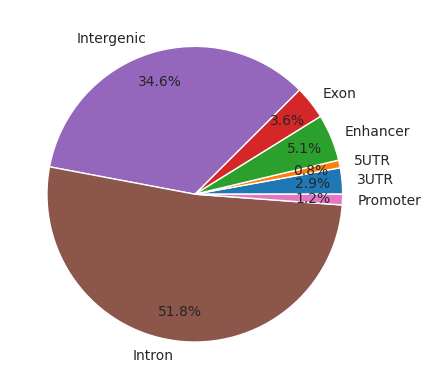

In [206]:
mc_pie = pd.DataFrame(
    mc_genic_df.loc[mc_genic_df["percentMeth"] > 0].groupby(
    ["feature_type", "method"], as_index=True)["feature_type"].count()).rename(
    columns={"feature_type" : "count"}).reset_index()

hmc_pie = pd.DataFrame(
    hmc_genic_df.loc[hmc_genic_df["percentMeth"] > 0].groupby(
    ["feature_type", "method"], as_index=True)["feature_type"].count()).rename(
    columns={"feature_type" : "count"}).reset_index()

In [143]:
mc_gene_df = mc_genic_df.groupby(["feature_name", "feature_type", "method"])["percentMeth"].mean().reset_index().groupby(["feature_type", "method"])["percentMeth"].mean().reset_index()
hmc_gene_df = hmc_genic_df.groupby(["feature_name", "feature_type", "method"])["percentMeth"].mean().reset_index().groupby(["feature_type", "method"])["percentMeth"].mean().reset_index()
gene_df = pd.concat([mc_gene_df, hmc_gene_df])
# gene_df = gene_df.loc[gene_df["feature_type"] != "Enhancer"]

gene_df["feature_type"] = pd.Categorical(gene_df["feature_type"], ["Promoter", "5UTR", "Exon", "Intron", "3UTR", "Intergenic", "Enhancer"])

In [147]:
mc_cgi = makeIntersect(
    pd.concat([nano_mc_df, wgbs_df]), cgi_features).groupby(
    ["feature_name", "feature_type", "method"])["percentMeth"].mean().reset_index().groupby(
    ["feature_type", "method"])["percentMeth"].mean().reset_index()
hmc_cgi_df = makeIntersect(
    pd.concat([nano_hmc_df, tab_df]), cgi_features).groupby(
    ["feature_name", "feature_type", "method"])["percentMeth"].mean().reset_index().groupby(
    ["feature_type", "method"])["percentMeth"].mean().reset_index()

cgi_df = pd.concat([mc_cgi, hmc_cgi_df])
cgi_df["feature_type"] = pd.Categorical(cgi_df["feature_type"], ["Open sea", "Upstream shelf", "Upstream shore", "CGI", "Downstream shore", "Downstream shelf"])

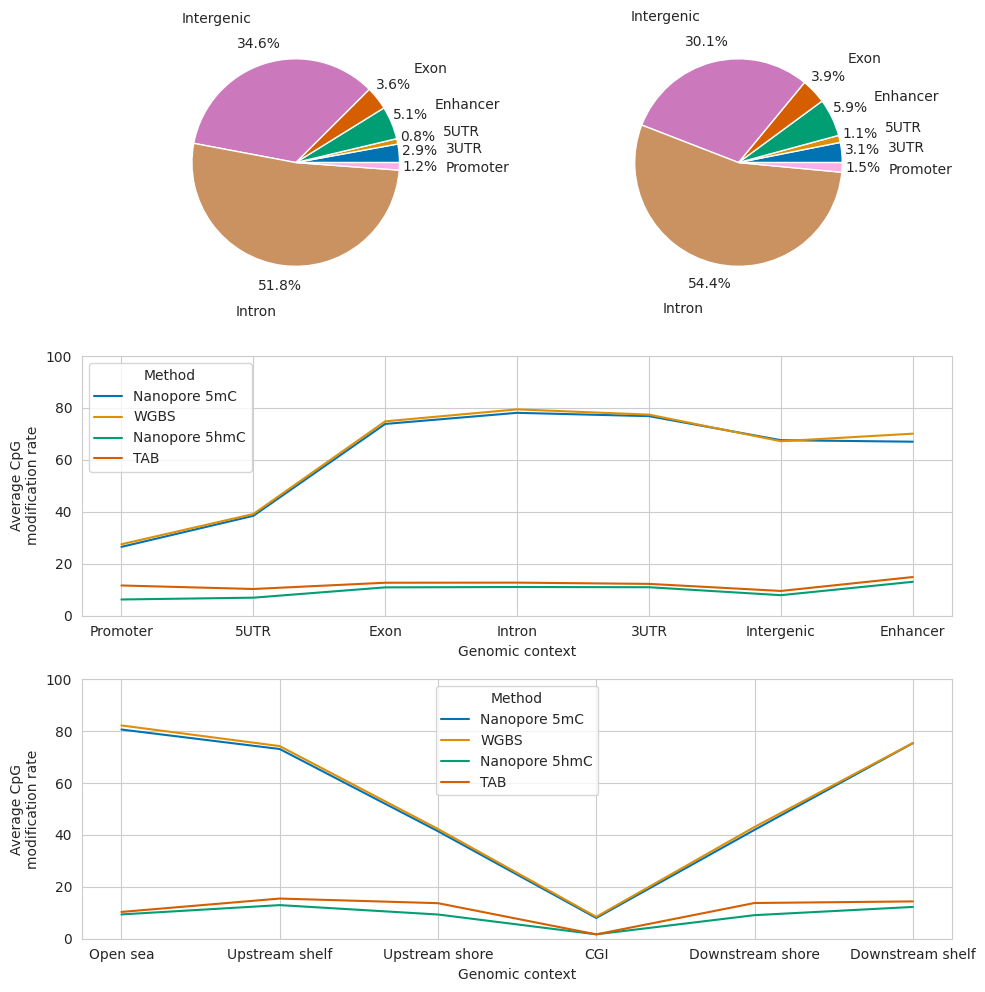

In [221]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

sns.set_style("whitegrid")
sns.set_palette("colorblind")

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(3, 2)

ax1 = fig.add_subplot(gs[0, 0])

ax1.pie(
    mc_pie.loc[mc_pie["method"] == "Nanopore 5mC", "count"], 
    labels=mc_pie.loc[mc_pie["method"] == "Nanopore 5mC", "feature_type"], 
    autopct='%1.1f%%', pctdistance=1.2, labeldistance=1.45)

ax2 = fig.add_subplot(gs[0, 1])

ax2.pie(
    hmc_pie.loc[hmc_pie["method"] == "Nanopore 5hmC", "count"], 
    labels=hmc_pie.loc[hmc_pie["method"] == "Nanopore 5hmC", "feature_type"], 
    autopct='%1.1f%%', pctdistance=1.2, labeldistance=1.45)

ax3 = fig.add_subplot(gs[1, :])
sns.lineplot(gene_df, x="feature_type", y="percentMeth", hue="method", ax=ax3)
ax3.set_ylim(0, 100)
ax3.set_xlabel("Genomic context")
ax3.set_ylabel("Average CpG\nmodification rate")
sns.move_legend(ax3, "upper left", title="Method")

ax4 = fig.add_subplot(gs[2, :])
sns.lineplot(cgi_df, x="feature_type", y="percentMeth", hue="method", ax=ax4)
ax4.set_ylim(0, 100)
ax4.set_xlabel("Genomic context")
ax4.set_ylabel("Average CpG\nmodification rate")
sns.move_legend(ax4, "upper center", title="Method")

fig.tight_layout()